#  <h1><center>Instacart - Market Basket Analysis</center></h1>

<img src="Instacart.jpg">
Img Source: Kaggle.com

## Table of Contents

1. Abstract

2. Introduction

3. Import libraries and reading csv's

4. Data Preparation and Data Cleaning
   
5. Exploratory Data Analysis

6. Word2Vec
   
7. Cultural Analysis

8. Apriori

9. XG-Boost

10. Logistic Regression

11. Random Forest

12. LGBM

13. Conclusion

14. References

# 1. Abstract

<img src="predict.jpg">

Market Basket Analysis is a modelling technique based upon the theory that if you buy a certain group of items, you are more (or less) likely to buy another group of items.
For example, if you are in an English pub and you buy a pint of beer and don't buy a bar meal, you are more likely to buy crisps (US. chips) at the same time than somebody who didn't buy beer.
In this analysis, a forecasting model is developed using machine learning algorithms to improve the accurately forecasts product sales.

###### The aim of this project is to predicting the products which have been purchased previously and the user is most likely to buy same products in their next order.

# 2. Introduction

It is a Kaggle competition and the participants were supposed to predict the next purchase item. The competition was called: Instacart Market Basket Analysis, Which products will an Instacart consumer purchase again?
After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.
In order to predict the sales we have compared different models like Word2Vec, Aprioris, Cultural Analysis, Random Forest and XGBoost.
Further to optimize the results we have used LightGBM. 
The data comes in the shape of multiple files, six to be specific!

###### Predictive Analytics is not new in this era of technological advancement. Using certain machine learning algorithms and Tensor Flows we have performed certain exploratory data analytics to figure out simple answers about the customer behavior. A lot has been done on the kernels in Kaggle. We have tried to tweak and extend on some kernels to find out more from the dataset.

# 3. Importing libraries and reading csv's

The libraries that we will be using are:

**Numpy** : NumPy is a library for the Python programming language, adding support for large, multi-dimensional   arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.


**Pandas** :  Pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.


**Matplotlib** : Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.


**Scikit-learn** : Scikit-learn is a machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.


**XgBoost** : XgBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.


**Keras** : Keras is a deep learning library that: Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility). Supports both convolutional networks and recurrent networks, as well as combinations of the two.


**LightGBM** : LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient



We shall be loading all the above libraries and several of their features which we will be using.

##### List of files imported and loaded

* Aisles.csv – This contains the names of the aisles based on the products in them.
* Departments.csv – It has the names of department categorized by products types.
* Order_Product_Prior – It has details of all the previous customer orders.
* Order_Product_Train.csv – This is the dataset which will be used to train the test dataset explained next.  
* Orders.csv – It is the main table containing details about the customer orders and also tells which record belongs to which table, train, prior or test.
* Products.csv – This contain detail of all the products sold by Instakart along with their ProductID.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

#Loading all the csv files

df_aisles = pd.read_csv("aisles.csv")
df_departments = pd.read_csv("departments.csv")
df_order_products_prior = pd.read_csv("order_products__prior.csv")
df_order_products_train = pd.read_csv("order_products__train.csv")
df_orders = pd.read_csv("orders.csv")
df_products = pd.read_csv("products.csv")

C:\Users\Parija\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 4. Data Prep and Cleaning

In [2]:
#Reading the orders.csv file
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
#Counting the number of rows and columns in orders.csv
df_orders.shape

(3421083, 7)

In [4]:
#Finding if the dataset has any null values
df_orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

* In the dataset there is a column called eval_set. It bascially tells us that to which csv (train or test) is the column corresponding to. Let us take the count of our test and train values.

# 5. Exploratory Data Analysis

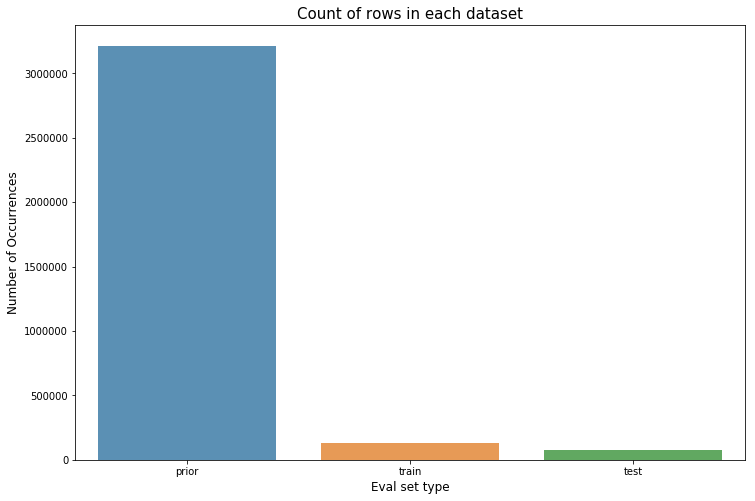

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [5]:
#Count no. of rows in each dataset
cnt_srs = df_orders.eval_set.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.show()
print(cnt_srs)

* So, in total there have been 3214874 orders and 131209 has been provided for training the model and we need to predict for 75000

In [6]:
#Finding number of customers
def get_unique_count(x):             ## Defining a function to get unique count for user_id from orders.csv
    return len(np.unique(x))

cnt_srs = df_orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

###### So, we figured out that there are total 206209 customers in total. We figured that out using the groupby for user_id and getting the unique count function.

##### Validating Dataset: It is told to us that the prior orders for any customer ranging between 4 to 100 is given. Validating it below.

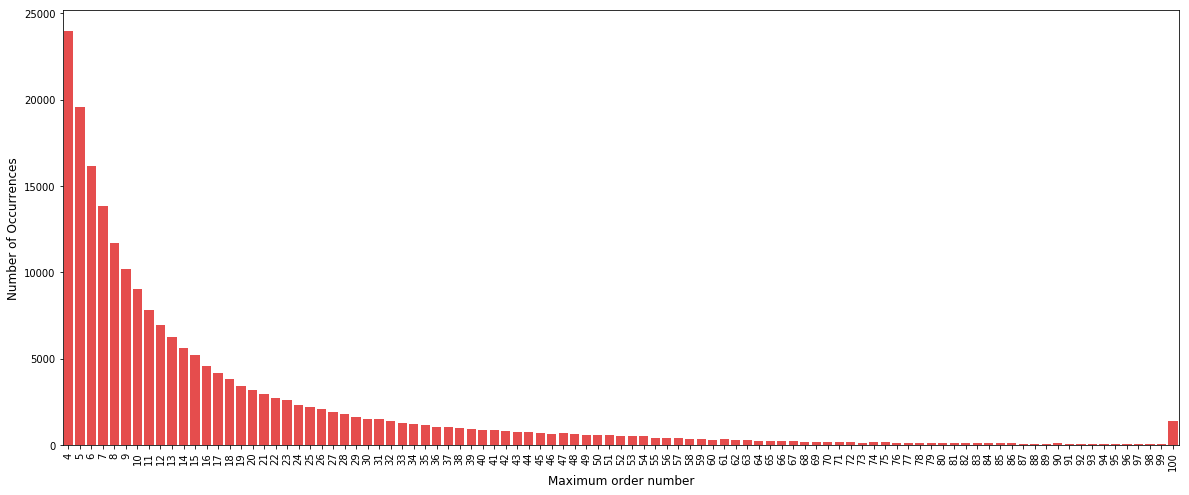

In [7]:
#Validating prior order range
cnt_srs = df_orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

#Bar-graph for the order-reorder counts
plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color = 'red')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So, as per the graph above, it is clear that minimum number of previous orders is 4 and maximum is 100

To know more about the customer ordering behaviour pattern, let us first see which day of the week has maximum number of orders.

In [8]:
#Changing the data labels into name of days of weeks
import calendar
days=[]

In [9]:
for i in df_orders['order_dow']:
    days.append(calendar.day_name[i])

In [10]:
#Adding another column for day-name of the week as per the number
df_orders['converted_dow']=days

In [11]:
df_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,converted_dow
0,2539329,1,prior,1,2,8,NaN,Wednesday
1,2398795,1,prior,2,3,7,15.0,Thursday
2,473747,1,prior,3,3,12,21.0,Thursday
3,2254736,1,prior,4,4,7,29.0,Friday
4,431534,1,prior,5,4,15,28.0,Friday
5,3367565,1,prior,6,2,7,19.0,Wednesday
6,550135,1,prior,7,1,9,20.0,Tuesday
7,3108588,1,prior,8,1,14,14.0,Tuesday
8,2295261,1,prior,9,1,16,0.0,Tuesday
9,2550362,1,prior,10,4,8,30.0,Friday


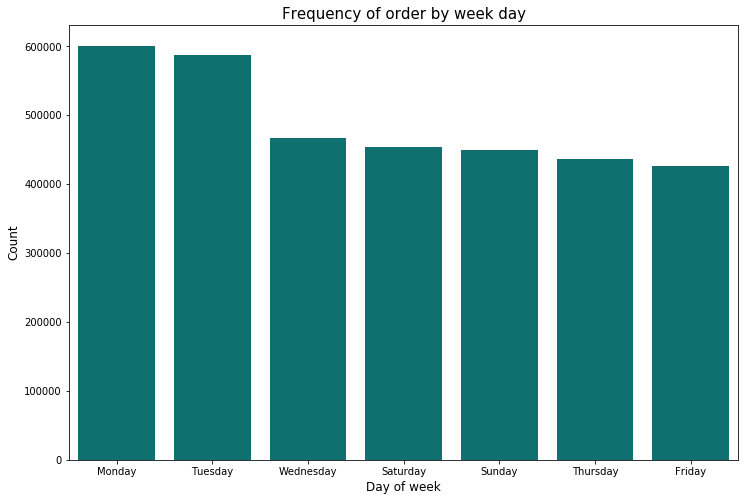

order_dow
0    600905
1    587478
2    467260
3    436972
4    426339
5    453368
6    448761
Name: order_id, dtype: int64

In [12]:
#Finding out the busiest day of the week
plt.figure(figsize=(12,8))
sns.countplot(x="converted_dow", data=df_orders, order=df_orders['converted_dow'].value_counts().index, color='teal')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()
cnt_dow = df_orders.groupby('order_dow')['order_id'].aggregate(get_unique_count)
cnt_dow

* We see that on days Monday and Tuesday maximum number of orders are being placed. So, it's during the weekend that most of the customers tend to order and then ordering tends to go down.
* Now, let us try to find out the time of the day when maximum orders are being placed like morning, evening or afternoon.

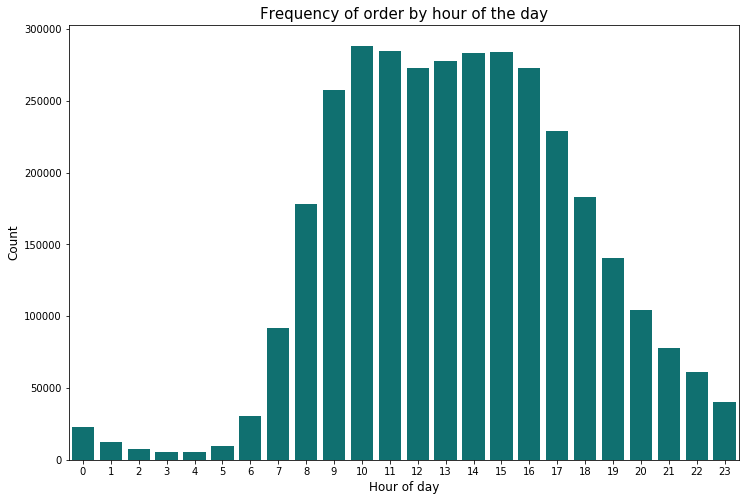

order_hour_of_day
0      22758
1      12398
2       7539
3       5474
4       5527
5       9569
6      30529
7      91868
8     178201
9     257812
10    288418
11    284728
12    272841
13    277999
14    283042
15    283639
16    272553
17    228795
18    182912
19    140569
20    104292
21     78109
22     61468
23     40043
Name: order_id, dtype: int64

In [13]:
#Figuring out which time of the day is the busiest
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=df_orders, color='teal')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Frequency of order by hour of the day", fontsize=15)
plt.show()
cnt_hod = df_orders.groupby('order_hour_of_day')['order_id'].aggregate(get_unique_count)
cnt_hod

###### So, the peak hours for ordering are during 10:00 AM to 3:00 PM on Monday and Tuesday. Let us just plot a heat map to make if more clear.

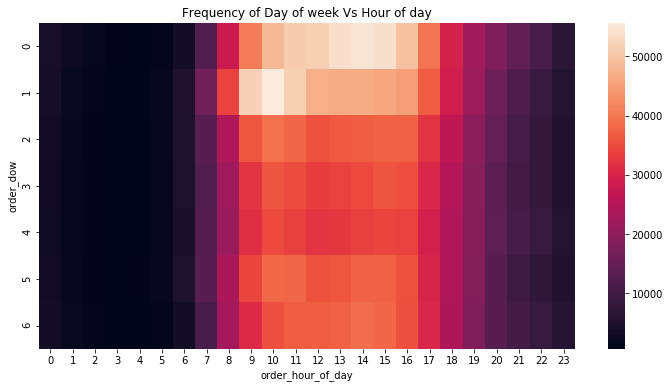

In [14]:
#Heat-map for the intersection of the day of week and hour of day
grouped_df = df_orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Let us now check what is the time period for reordering using the column called days_since_prior order.

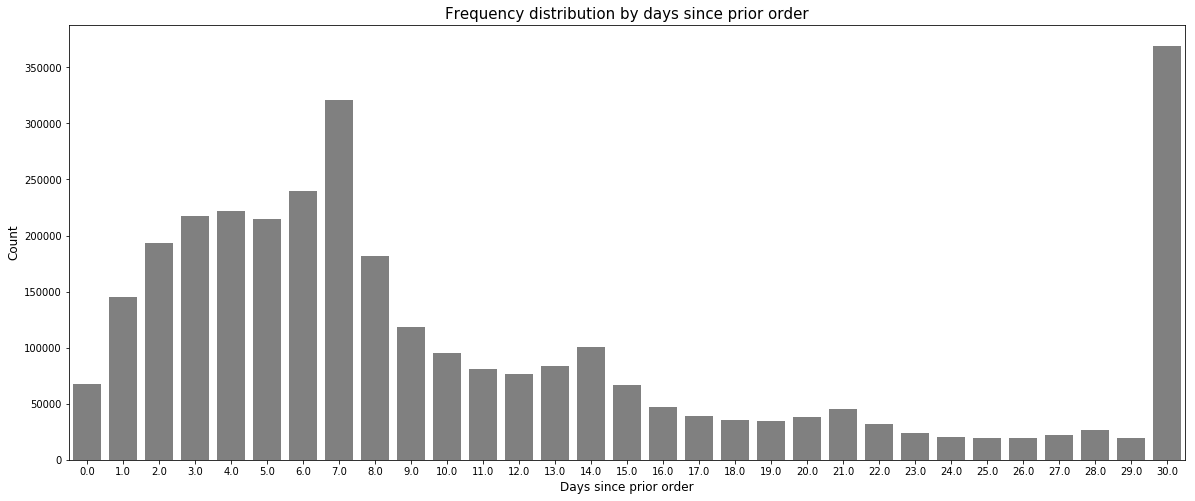

In [15]:
#Finding out after how many days an order is reordered
plt.figure(figsize=(20,8))
sns.countplot(x="days_since_prior_order", data=df_orders, color='grey')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

* Conclusion: Customers tend to reorder after a period of 7 days or 30 days, i.e. weekly or monthly.

In [16]:
# percentage of re-orders in prior set #
df_order_products_prior.reordered.sum() / df_order_products_prior.shape[0]

0.5896974667922161

In [17]:
# percentage of re-orders in train set #
df_order_products_train.reordered.sum() / df_order_products_train.shape[0]

0.5985944127509629

So, on an average, 59% of the ordered products are reordered again.

Let us see the number of products bought in each order.

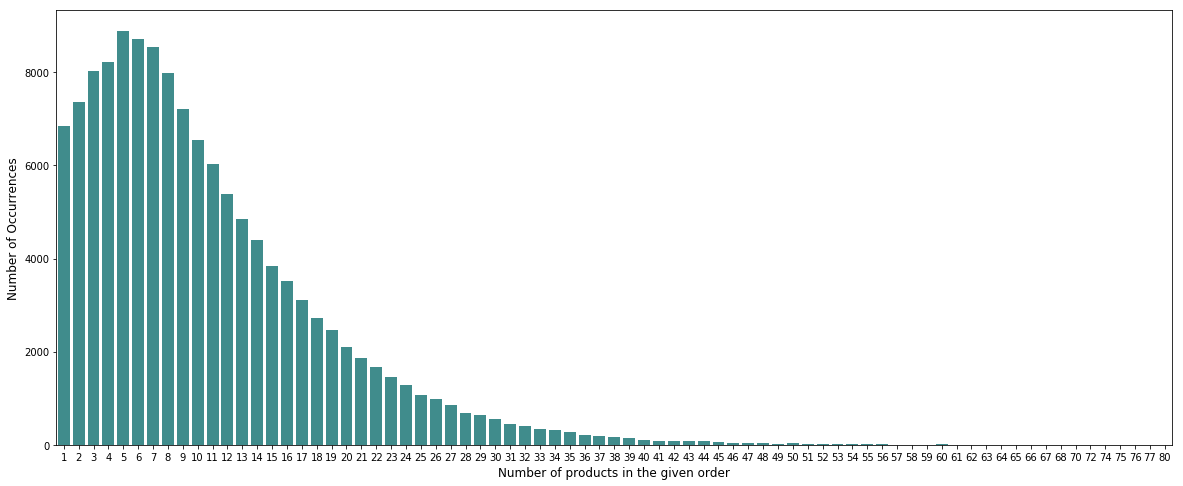

In [18]:
#No. of products per order on an average
grouped_df = df_order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color = 'teal')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
#plt.xticks(rotation='vertical')
plt.show()

So, mostly 5 items per order

Let us merge the tables to get a greater overview of our dataset.

In [19]:
df_order_products_prior = pd.merge(df_order_products_prior, df_products, on='product_id', how='left')
df_order_products_prior = pd.merge(df_order_products_prior, df_aisles, on='aisle_id', how='left')
df_order_products_prior = pd.merge(df_order_products_prior, df_departments, on='department_id', how='left')
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


Let's have a look at the top grossing products

In [20]:
#Counting the total no of products purchased, i.e. the most popular products.
cnt_srs = df_order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


So, it mostly fruits which customers prefer to buy. So, hopefully the most used aisles should correspond to fruits. Let us look at that.

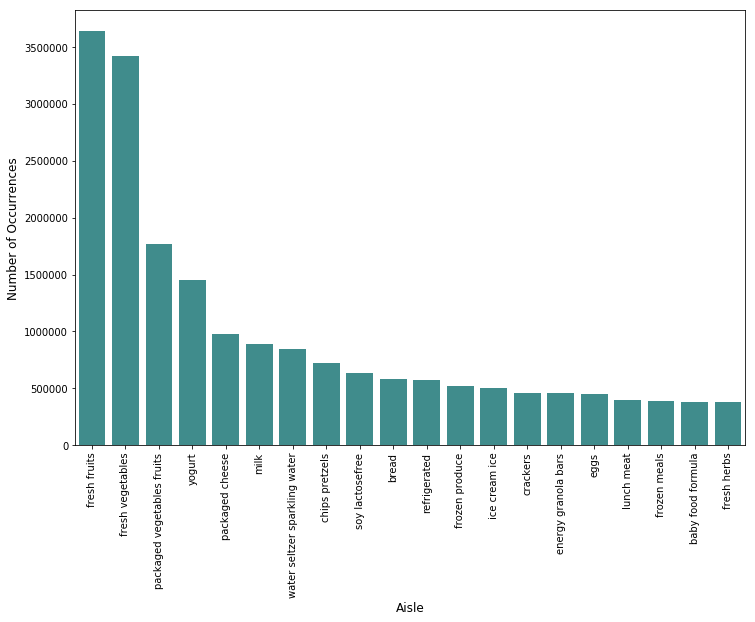

In [21]:
#Count for the sales according to the aisles
cnt_srs = df_order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='teal')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* Clearly, fresh fruits and fresh vegetables are the top grossing products and their aisles are the most shopped from.

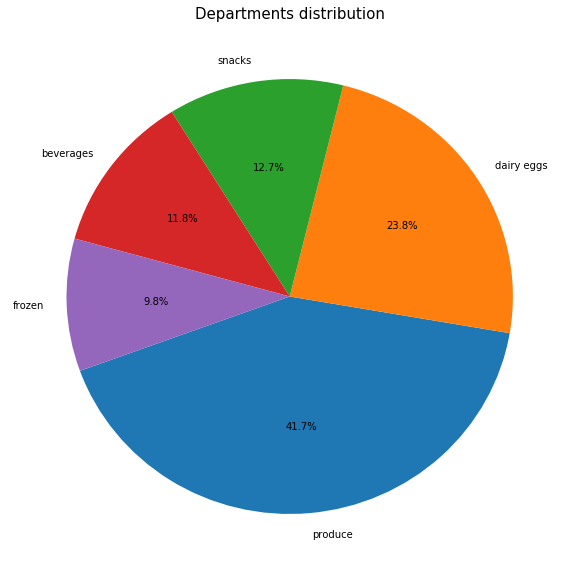

In [22]:
# Pie-chart for department-wise sales.
plt.figure(figsize=(10,10))
temp_series = df_order_products_prior['department'].value_counts().head(5)
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

* It is clear that the produce department is selling the most. We were hoping it to be frozen because it has meat  but clearly people priorotise fruits and veggies over meat.

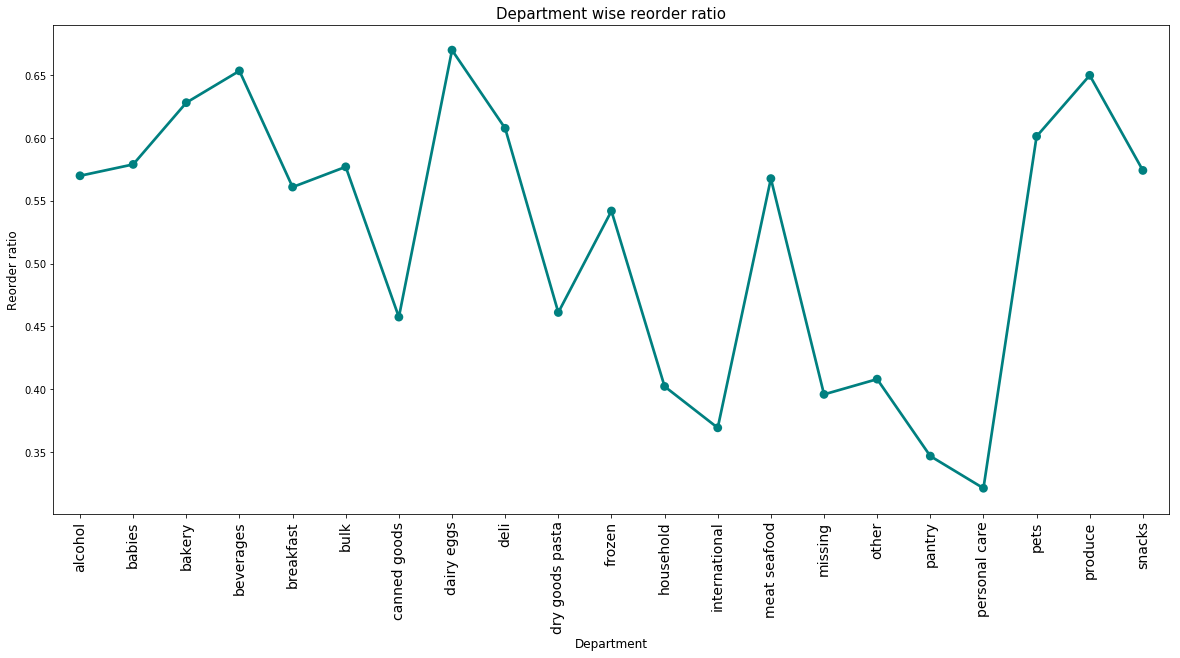

In [23]:
# Finding the reorder ratio with respect to Department.
# This means if a certain product is ordered previously, what are the chances that it will be reordered again.
grouped_df = df_order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(20,9))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color='teal')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical',fontsize=14)
plt.show()

* Dairy eggs have the reorder ratio and personal care has the lowest.

* Below we are trying to figure out if the reordering of a product depends on the order in which it was added to the cart.

C:\Users\Parija\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


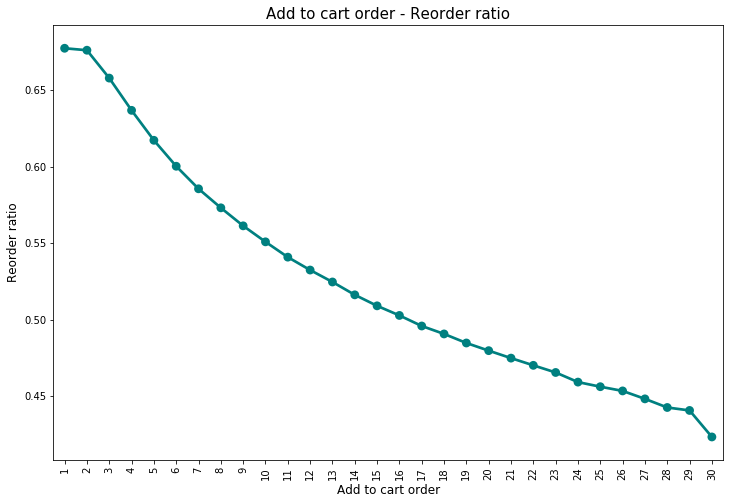

In [24]:
#Add to cart order - reorder ratio
# Here we are trying to understand if the order in which a product was added to the cart will affect it's chances of reordering
df_order_products_prior["add_to_cart_order_mod"] = df_order_products_prior["add_to_cart_order"].copy() # Making a copy of order_products_prior
df_order_products_prior["add_to_cart_order_mod"].loc[df_order_products_prior["add_to_cart_order_mod"]>30] = 30
grouped_df = df_order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color='teal')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* So, the order in which you out items in your cart does matter when you reorder. This makes sense to us as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

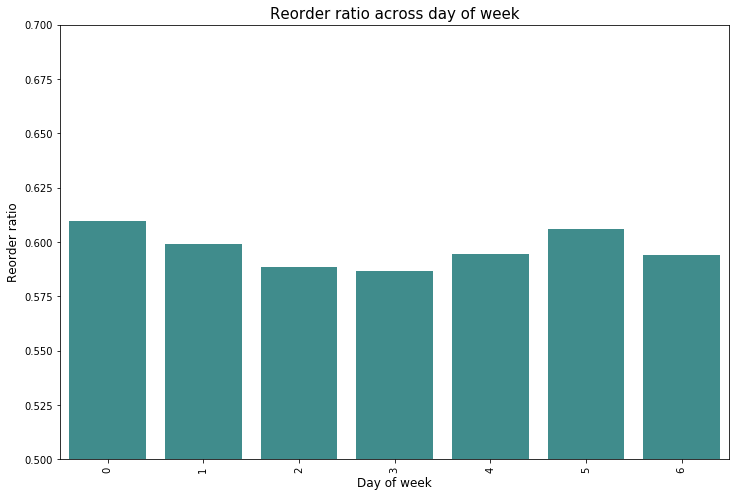

In [25]:
# Reorder ratio across the day of week
df_order_products_train = pd.merge(df_order_products_train, df_orders, on='order_id', how='left')
grouped_df = df_order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color='teal')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

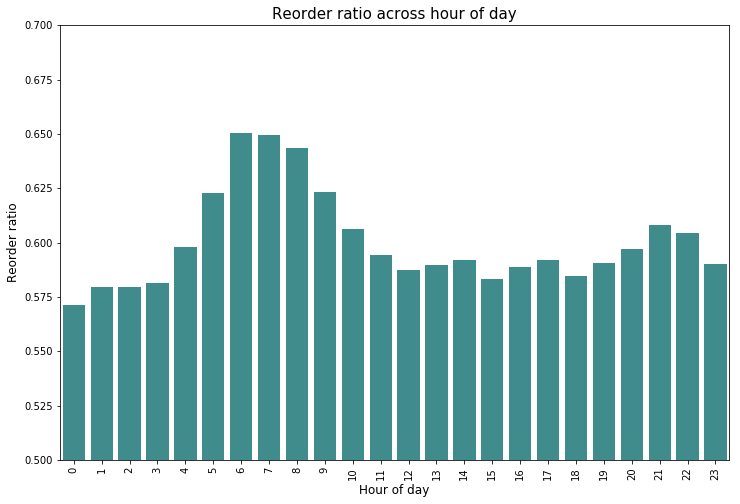

In [26]:
#Reorder ration across hour od day
grouped_df = df_order_products_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color='teal')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

# 6. Word2Vec

The orders can act as sentences and product ids can act as words, in this techniques we will see if the model will learn any useful information about the products from the order history of all users, maybe in the future this can be used as input to a classifier that recommends products.

In [27]:
# Reading csv's
train_orders = pd.read_csv("order_products__train.csv")
prior_orders = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv").set_index('product_id')

In [28]:
# Coverting product_id's to string
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

In [29]:
# Grouping by order_id
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [30]:
# Joining 
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values

In [31]:
# Using the Word2Vec package from Gensim model
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

In [32]:
# Creating a list
vocab = list(model.wv.vocab.keys())

In [33]:
# Importing PCS from Ski-kit learn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

C:\Users\Parija\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [34]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(21, 21))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\Parija\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
C:\Users\Parija\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


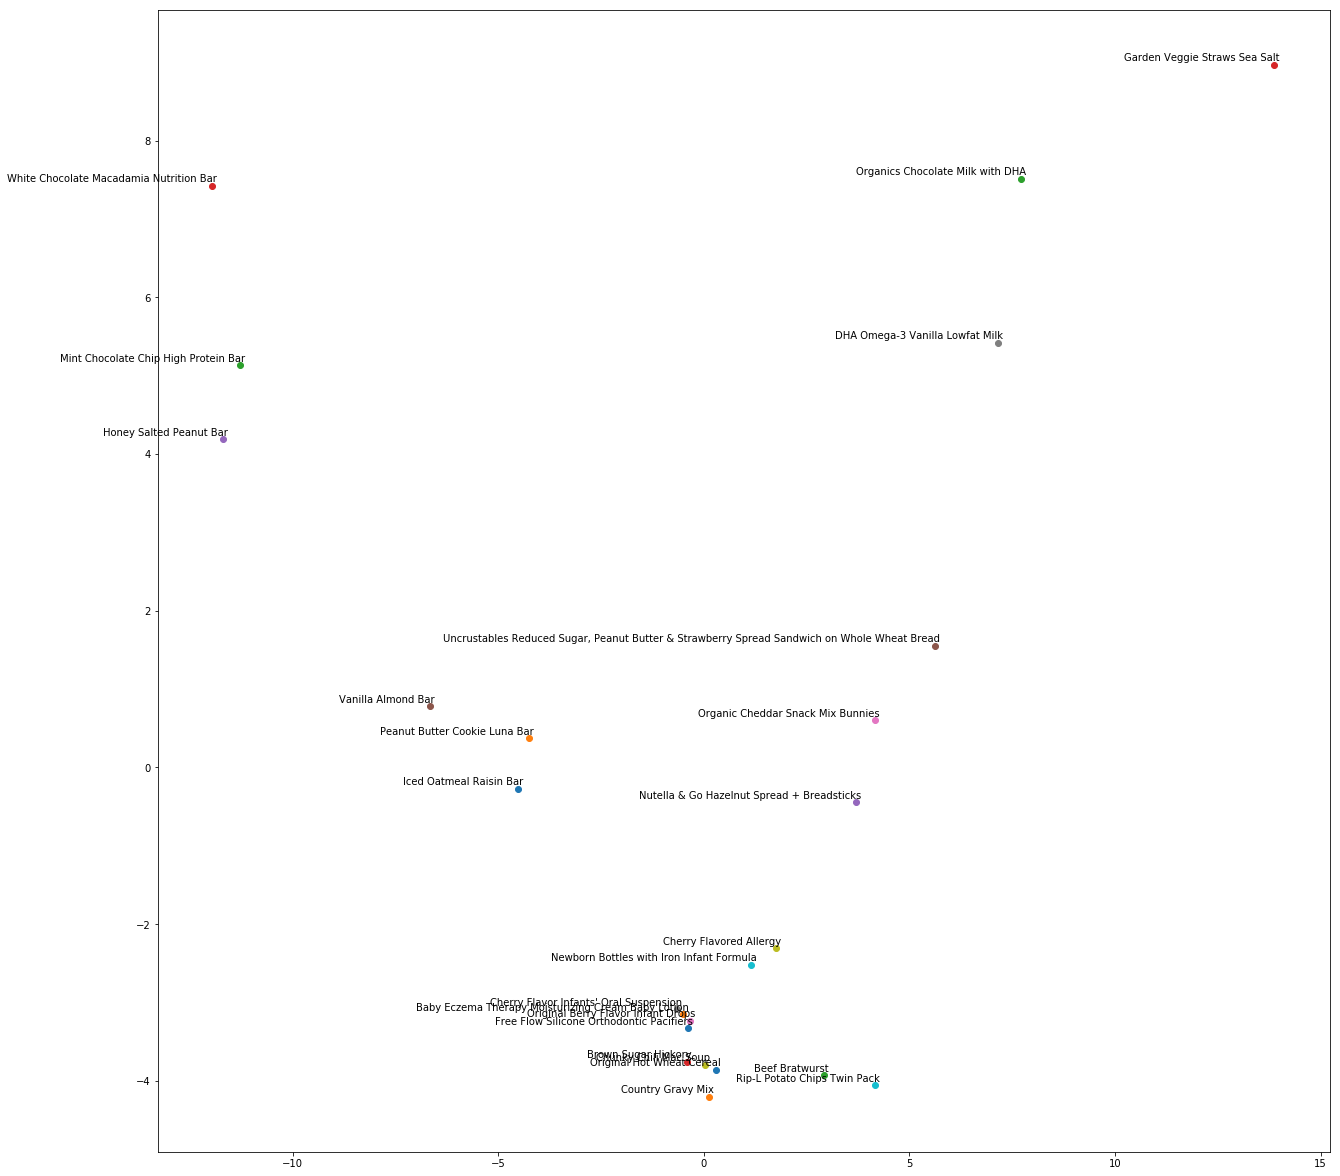

In [35]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=4):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

# 7. Cultural Analysis

In [36]:
# Created a bag of words to find out which cultures product are selling the most.
df_bow = pd.read_csv("bow.csv")

In [37]:
#Bag of Words with Name of Cultures
df_bow.Culture_names

0      Afrikaans
1       Albanian
2         Arabic
3       Armenian
4          Azeri
5         Basque
6     Belarusian
7      Bulgarian
8        Catalan
9        Chinese
10      Croatian
11         Czech
12        Danish
13       Dhivehi
14         Dutch
15       English
16      Estonian
17       Faroese
18         Farsi
19       Finnish
20        French
21      Galician
22      Georgian
23        German
24         Greek
25      Gujarati
26        Hebrew
27         Hindi
28     Hungarian
29     Icelandic
         ...    
37        Kyrgyz
38       Latvian
39    Lithuanian
40    Macedonian
41         Malay
42       Marathi
43     Mongolian
44     Norwegian
45        Polish
46    Portuguese
47       Punjabi
48      Romanian
49       Russian
50      Sanskrit
51       Serbian
52        Slovak
53     Slovenian
54       Spanish
55       Swahili
56       Swedish
57        Syriac
58         Tamil
59         Tatar
60        Telugu
61          Thai
62       Turkish
63     Ukrainian
64          Ur

In [38]:
for x in df_bow.Culture_names :
    print(x)

Afrikaans
Albanian
Arabic
Armenian
Azeri
Basque
Belarusian
Bulgarian
Catalan
Chinese
Croatian
Czech
Danish
Dhivehi
Dutch
English
Estonian
Faroese
Farsi
Finnish
French
Galician
Georgian
German
Greek
Gujarati
Hebrew
Hindi
Hungarian
Icelandic
Indonesian
Italian
Japanese
Kannada
Kazakh
Konkani
Korean
Kyrgyz
Latvian
Lithuanian
Macedonian
Malay
Marathi
Mongolian
Norwegian
Polish
Portuguese
Punjabi
Romanian
Russian
Sanskrit
Serbian
Slovak
Slovenian
Spanish
Swahili
Swedish
Syriac
Tamil
Tatar
Telugu
Thai
Turkish
Ukrainian
Urdu
Uzbek
Vietnamese


In [39]:
df_products.product_name

0                               Chocolate Sandwich Cookies
1                                         All-Seasons Salt
2                     Robust Golden Unsweetened Oolong Tea
3        Smart Ones Classic Favorites Mini Rigatoni Wit...
4                                Green Chile Anytime Sauce
5                                             Dry Nose Oil
6                           Pure Coconut Water With Orange
7                        Cut Russet Potatoes Steam N' Mash
8                        Light Strawberry Blueberry Yogurt
9           Sparkling Orange Juice & Prickly Pear Beverage
10                                       Peach Mango Juice
11                              Chocolate Fudge Layer Cake
12                                       Saline Nasal Mist
13                          Fresh Scent Dishwasher Cleaner
14                                Overnight Diapers Size 6
15                           Mint Chocolate Flavored Syrup
16                                       Rendered Duck F

In [40]:
#Dictionary
cultname=[]

In [41]:
#Splitting each Product in sepaarte Words
for i in df_products.product_name:
    a=i.split()
    for j in df_bow.Culture_names:
        if j in a:
            cultname.append(j)
            

In [42]:
#Combining the pair in dictionary
counts = dict()
for i in cultname:
    counts[i] = counts.get(i,0) + 1
print(counts)

{'Italian': 400, 'French': 348, 'Danish': 18, 'English': 118, 'Chinese': 25, 'Greek': 506, 'Thai': 113, 'Spanish': 38, 'Norwegian': 6, 'Polish': 41, 'German': 20, 'Korean': 22, 'Russian': 15, 'Japanese': 29, 'Swedish': 19, 'Portuguese': 3, 'Dutch': 18, 'Bulgarian': 7, 'Punjabi': 5, 'Icelandic': 23, 'Basque': 1, 'Turkish': 10, 'Vietnamese': 11, 'Mongolian': 3, 'Armenian': 1, 'Lithuanian': 1, 'Indonesian': 3, 'Hungarian': 3}


In [43]:
counts.keys()

dict_keys(['Italian', 'French', 'Danish', 'English', 'Chinese', 'Greek', 'Thai', 'Spanish', 'Norwegian', 'Polish', 'German', 'Korean', 'Russian', 'Japanese', 'Swedish', 'Portuguese', 'Dutch', 'Bulgarian', 'Punjabi', 'Icelandic', 'Basque', 'Turkish', 'Vietnamese', 'Mongolian', 'Armenian', 'Lithuanian', 'Indonesian', 'Hungarian'])

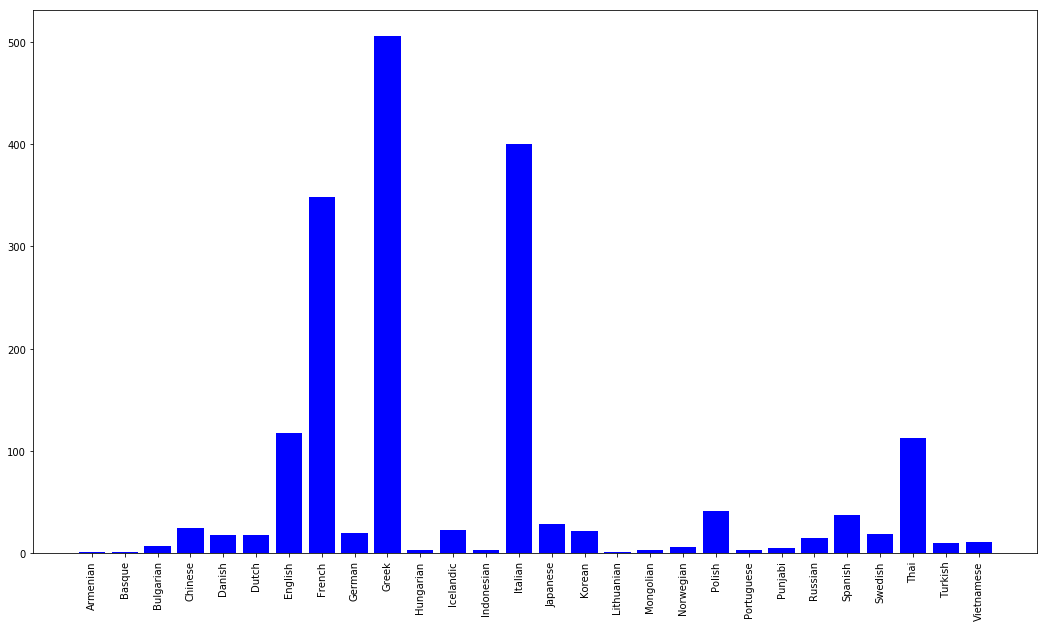

In [44]:
#Bar plot of Dictionary
plt.figure(figsize=(18,10))
plt.bar(counts.keys(),counts.values(),color='b')
plt.xticks(rotation='vertical')
plt.show()

###### Output: Greek and Italian are the most sold products.

* The text in the document is from Instacart Kaggle Competition is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/
* The code in the document by J. Hamilton,TowardsDataScience is licensed under the MIT License https://opensource.org/licenses/MIT

# 8. Apriori's

In [45]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

%matplotlib inline

In [46]:
# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [47]:
orders = pd.read_csv('order_products__prior.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (32434489, 4);   size: 1037.90 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [48]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value

orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

MemoryError: 

In [ ]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))
#orders.index.unique gives unique number of orders
#orders.value_counts gives unique values of item_id

In [ ]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")


In [ ]:
#freq(orders)
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))

In [ ]:
# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair

In [ ]:
# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


In [ ]:
# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]               

In [ ]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [ ]:
%%time
rules = association_rules(orders, 0.01)  

In [ ]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

* The text in the document by 'Instacart Kaggle Competition' is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/
* The code in the document by 'datatheque' Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT

# 9. XG-Boost

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

Changing current working directory

In [ ]:
import os
cwd = os.getcwd()
print (cwd)
%cd "/Users/rishikadawkar/Desktop/ADS /Instacart data"

Let's get the list of all the input files

In [ ]:
from subprocess import check_output
print(check_output(["ls", "../Instacart data"]).decode("utf8"))

Read Inputs into data frame

In [ ]:
order_products_train = pd.read_csv("../Instacart data/order_products__train.csv")
order_products_prior = pd.read_csv("../Instacart data/order_products__prior.csv")
orders = pd.read_csv("../Instacart data/orders.csv")
products = pd.read_csv("../Instacart data/products.csv")
aisles = pd.read_csv("../Instacart data/aisles.csv")
departments = pd.read_csv("../Instacart data/departments.csv")

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [ ]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

Now, let's concatenate them in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers

In [ ]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

##### Missing Data in all orders

In [ ]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

There is no missing data in order_products_all dataset

##### Reorder Frequency

In [ ]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

* 59 % of ordered products are previously ordered by customers.

In [ ]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

* Step 1 - We will start with reading the orders file.

In [ ]:
data_path = "../Instacart data/"
orders_df = pd.read_csv(data_path + "orders.csv", usecols=["order_id","user_id","order_number"])

Since the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

* Step 2 - Create data frame with old purchase

In [ ]:
# read the prior order file #
prior_df = pd.read_csv(data_path + "order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

* Step 3 - Create data frame with latest purchase

In [ ]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

* Step 4 - Get count of Number of reorders

In [ ]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

* Step 5 - Merge the prior df with latest df

In [ ]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

* Step 6 - Get distinct order id in train_df. This will help in joining the data frame with orders

In [ ]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

In [ ]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

In [ ]:
test_df = pd.read_csv(data_path + "sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

* Step 7 - Prepare test data frames

In [ ]:
print(train_df.shape, test_df.shape)

* Step 8 - Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [ ]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

In [ ]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

In [ ]:
products_df = pd.read_csv(data_path + "products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

* Step 9 - Add more features to training data from Products data frame

In [ ]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

In [ ]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

Now we have all the products that has been purchased previously by the customer along with some characteristics / featrures. So we can use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [ ]:
train_y_df = pd.read_csv(data_path + "order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

In [ ]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X=train_df.drop('reordered',axis=1)

In [ ]:
X.head()

In [ ]:
Y =train_df['reordered']

In [ ]:
Y.head()

* Step 10 - Split data into train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [ ]:
model = XGBClassifier()

* Step 11 - Train the model using XGBClassifier.

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
predictions = [round(value) for value in y_pred]

In [ ]:
predictions = [round(value) for value in y_pred]

### Accuracy for the  XGBoost Classifier

In [ ]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# target variable for train set #
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

* Step 12 - Create XGb function.

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

* Step 13 - Run the XGB function on training np array.

In [ ]:
# run the xgboost model #
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.ix[out_df["Pred"].astype('int')==1]

In [ ]:
# when there are more than 1 product, merge them to a single string #
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

* Step 14 - Load result in the output file.

In [ ]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv(data_path + "sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("xgb_starter_3450.csv", index=False)

In [ ]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

# 10. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [ ]:
#fitting the model
clf.fit(X_train, y_train)

In [ ]:
#predictions
pred=clf.predict(X_test)

In [ ]:
#accuracy score of Logistic Regression Model
print(accuracy_score(pred, y_test))

# 11. Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [ ]:
clfrf.fit(X_train, y_train)

In [ ]:
#predictions
predrf=clfrf.predict(X_test)

In [ ]:
#accuracy score for the random forest model
accuracy_score(predrf, y_test)

# 12. Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

In [ ]:
model= lgb.LGBMClassifier()

In [ ]:
model.fit(X_train, y_train)

In [ ]:
pred=model.predict(X_test)

In [ ]:
pred=model.predict(X_test)

In [ ]:
#accuracy score of Light GBM
print(accuracy_score(pred, y_test))

* The text in the document is from source Instacart Kaggle Competition is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/
* The code in the document is by Onodera is licensed under the MIT License https://opensource.org/licenses/MIT

# 13. Conclusion
We are getting following results on applying data set on different models:

| Model | R2 Score |
| --- | --- |
| Logistic Regression | 0.901 |
| Random Forest Regression  | 0.904 |
| XG Boost | 0.904 |
| LGBM | 0.904 |




# 14. References

[1] Cui, G., Wong, M. L., & Lui, H. K. (2006). Machine learning for direct marketing response models:
Bayesian networks with evolutionary programming.Management Science, 52(4), 597-612

[2] https://www.kaggle.com/omarito/word2vec-for-products-analysis-0-01-lb

[3] https://en.wikipedia.org/wiki/Xgboost

[4] https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vsxgboost/

* The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

* The text in the document by Analytics Vidhya is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

* The text in the document by towards data science is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

* The code in the document by Source Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT